In [1]:
"""
Analyze GRASP for each detector design
author: Jiancheng Zeng
Date: May 1, 2023
"""

'\nAnalyze GRASP for each detector design\nauthor: Jiancheng Zeng\nDate: May 1, 2023\n'

In [2]:
# You don't need to change anything in this code block unless you want to define your own changes.
import pandas as pd
import numpy as np
import time
import math
import matplotlib.pyplot as plt

# this function calculate distance in 3D space
def calculate_distance(x1, y1, z1, x2, y2, z2):
    distance = math.hypot(math.hypot(x2 - x1, y2 - y1), z2 - z1)
    return distance
  
def read_data_from_toymodel(file_path):
    print("Reading data...\n")
    try:
        df = pd.read_csv(file_path, delimiter='\t')  # Assumes tab-separated values in the text file

        # Name each data group with event ID
        grouped = df.groupby(df.iloc[:, 0])

        # Create an empty dictionary to store the 3D data structure
        data_3d = {}

        # Iterate over each group and populate the dictionary
        for group_name, group_data in grouped:
            data_3d[group_name] = group_data.values
        
        print("Toy Model data imported\nFound " + str(len(list(data_3d.keys()))) + " Events!")
        return data_3d
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None
    except pd.errors.ParserError:
        print(f"Error: Unable to parse data from '{file_path}'. Please ensure the file has the correct format.")
        return None

""" 
This function doing GRASP analysis
"""
def Analyze_GRASP(data_3d, particle_ID, stop_event=False, in_flight_event=False):
    
    # This is the event number in the raw data
    Event_list = list(data_3d.keys())
    
    # Construct a empty vector for initial energy store
    Init_Energy = []
    
    # Counting the number of stop events
    N_stop_event = 0
    
    
    for i in range(len(Event_list)):
        # general condition that all the events has to match, here shows the last point is inside Liquid Argon
        condition = data_3d[Event_list[i]][data_3d[Event_list[i]][:, 8] == np.min(data_3d[Event_list[i]][:, 8])][0, 6] == 'LAr' 
        # conditions for stop events, here shows last point has 0 energy left and 0 energy deposit
        condition_stop = np.min(data_3d[Event_list[i]][:, 8]) == 0 and np.min(data_3d[Event_list[i]][:, 9]) == 0 and stop_event
        # conditions for in flight annihilation events, here shows last point has energy larger than 0
        condition_in_flight = np.min(data_3d[Event_list[i]][:, 8]) != 0 and in_flight_event
        
        if(condition_stop or condition_in_flight and condition):
            N_stop_event = N_stop_event + 1
            Init_Energy.append(data_3d[Event_list[i]][0, 8])
        print("Now processing (" + str(i) + "/" + str(len(Event_list))+")",  end='\r')
    print("\n We got " + str(N_stop_event) + " events selected")
    print("Last event is "+ str(Event_list[len(Event_list)-1]))
    
    # return two things, first one is the inital energy array and second one is the number of the event generated.
    return np.array(Init_Energy), Event_list[len(Event_list)-1]

"""
This function analyze distance traveled inside LAr
"""
def Analyze_trace(data_3d, particle_ID, stop_event=False, in_flight_event=False):
    
    # This is the event number in the raw data
    Event_list = list(data_3d.keys())
    
    # Construct a empty vector for initial energy store
    Init_Energy = []
    
    # record the depth that primary particle traveled inside LAr
    Depth = []
    
    # record the distance that primary particle traveled inside LAr
    Distance = []
    
    for i in range(len(Event_list)):
        # general condition that all the events has to match, here shows the last point is inside Liquid Argon
        condition = data_3d[Event_list[i]][data_3d[Event_list[i]][:, 8] == np.min(data_3d[Event_list[i]][:, 8])][0, 6] == 'LAr' 
        # conditions for stop events, here shows last point has 0 energy left and 0 energy deposit
        condition_stop = np.min(data_3d[Event_list[i]][:, 8]) == 0 and np.min(data_3d[Event_list[i]][:, 9]) == 0 and stop_event
        # conditions for in flight annihilation events, here shows last point has energy larger than 0
        condition_in_flight = np.min(data_3d[Event_list[i]][:, 8]) != 0 and in_flight_event
        
        if(condition_stop or condition_in_flight and condition):
            x1 = data_3d[Event_list[i]][data_3d[Event_list[i]][:, 8] == np.min(data_3d[Event_list[i]][:, 8])][0, 16]
            y1 = data_3d[Event_list[i]][data_3d[Event_list[i]][:, 8] == np.min(data_3d[Event_list[i]][:, 8])][0, 17]
            z1 = data_3d[Event_list[i]][data_3d[Event_list[i]][:, 8] == np.min(data_3d[Event_list[i]][:, 8])][0, 18]
            minimum_time = np.min(data_3d[Event_list[i]][data_3d[Event_list[i]][:, 6] == 'LAr'][:, 7])
            x2 = data_3d[Event_list[i]][data_3d[Event_list[i]][:, 7] == minimum_time][0, 16]
            y2 = data_3d[Event_list[i]][data_3d[Event_list[i]][:, 7] == minimum_time][0, 17]
            z2 = data_3d[Event_list[i]][data_3d[Event_list[i]][:, 7] == minimum_time][0, 18]
            #print(minimum_time)
            Distance.append(calculate_distance(x1, y1, z1, x2, y2, z2))
            Depth.append(z2-z1)
            Init_Energy.append(data_3d[Event_list[i]][0, 8])
        print("Now processing (" + str(i) + "/" + str(len(Event_list))+")",  end='\r')
    print("\n We got " + str(len(Depth)) + " events selected")
    print("Last event is "+ str(Event_list[len(Event_list)-1]))
    
    # return two things, first one is the inital energy array and second one is the depth traveled inside LAr.
    return np.array(Init_Energy), np.array(Depth), np.array(Distance)

def Analyze_TOF(data_3d, particle_ID, stop_event=False):
    Event_list = list(data_3d.keys())
    TOF_out_E = []
    TOF_in_E = []
    for i in range(len(Event_list)):
        Energy_out = 0
        Energy_in = 0
        for j in range(len(data_3d[Event_list[i]])):
            if(str(data_3d[Event_list[i]][j, 5]) == '-10000' or str(data_3d[Event_list[i]][j, 5]) == '-10001' or str(data_3d[Event_list[i]][j, 5]) == '-10002' or str(data_3d[Event_list[i]][j, 5]) == '-10003' or str(data_3d[Event_list[i]][j, 5]) == '-10004' or str(data_3d[Event_list[i]][j, 5]) == '-10005' and str(data_3d[Event_list[i]][3]) == str(particle_ID)):
                Energy_out = Energy_out + float(data_3d[Event_list[i]][j, 9])
                #print(Energy_out)
                #if str(data_3d[Event_list[i]][j+1, 5]) != str(data_3d[Event_list[i]][j, 5]):
                    #break
            if(str(data_3d[Event_list[i]][j, 5]) == '-11000' or str(data_3d[Event_list[i]][j, 5]) == '-11001' or str(data_3d[Event_list[i]][j, 5]) == '-11002' or str(data_3d[Event_list[i]][j, 5]) == '-11003' or str(data_3d[Event_list[i]][j, 5]) == '-11004' or str(data_3d[Event_list[i]][j, 5]) == '-11005' and str(data_3d[Event_list[i]][3]) == str(particle_ID)):
                Energy_in = Energy_in + float(data_3d[Event_list[i]][j, 9])
        if(stop_event==True):
            condition = np.min(data_3d[Event_list[i]][:, 8]) == 0 and np.min(data_3d[Event_list[i]][:, 9]) == 0 and stop_event
        else:
            condition = True

        if(Energy_in != 0 and Energy_out != 0 and condition):
            TOF_out_E.append(Energy_out)
            TOF_in_E.append(Energy_in)
        print("Now processing (" + str(i) + "/" + str(len(Event_list))+")",  end='\r')
    Result_Vector = np.array([TOF_out_E, TOF_in_E])
    print("\n")
    print("number of events is:"+str(Event_list[len(Event_list)-1]))
    return Result_Vector, Event_list[len(Event_list)-1]

def GRASP_hist(GRASP_vector, particle_ID, label, total_event, energy_min, energy_max, num_bins, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    GRASP_bin = []
    
    Xaxis = np.linspace(energy_min, energy_max, num_bins + 1) / number_of_nucleons(particle_ID)[1]
    centersXaxis = Xaxis[:-1] + np.diff(Xaxis) / 2

    for i in range(num_bins):
        bin_start = i * ((energy_max - energy_min) / num_bins)
        bin_end = (i + 1) * ((energy_max - energy_min) / num_bins)
        GRASP_bin.append(400 * math.pi * len(GRASP_vector[(GRASP_vector > bin_start) & (GRASP_vector < bin_end)]) / (total_event / num_bins))
        
        # For debugging each bin
        # print("GRASP_bin[" + str(i) + "] is " + str(GRASP_bin[i]))
        
    ax.step(centersXaxis, GRASP_bin, where='mid', label=str(label)+"("+str(len(GRASP_vector))+" events)", alpha=0.8)
    ax.set_xlabel("energy [MeV/n]")
    ax.set_ylabel("GRASP [m^2 sr]")
    ax.legend()
    ax.grid(alpha=0.2)
    ax.set_title('GRASP (Geometric Acceptance)')
    return ax

def number_of_nucleons(particle_ID):
    data = [[2212, 1000010020, 1000020030, -2212, -1000010020, -1000020030],
            [1, 2, 3, 1, 2, 3]]
    df = pd.DataFrame(data, columns=['proton', 'deuteron', 'helium3', 'antiproton', 'antideuteron', 'antihelium3'])
    matching_columns = df.columns[df.eq(particle_ID).any()]
    particle_info = df[matching_columns[0]]
    return particle_info


Reading data...

Toy Model data imported
Found 1312 Events!
Now processing (1311/1312)
 We got 1312 events selected
Last event is 999553
Reading data...

Toy Model data imported
Found 1331 Events!
Now processing (1330/1331)
 We got 1331 events selected
Last event is 998550
Reading data...

Toy Model data imported
Found 1619 Events!
Now processing (1618/1619)
 We got 1619 events selected
Last event is 999923
Reading data...

Toy Model data imported
Found 1941 Events!
Now processing (1940/1941)
 We got 1941 events selected
Last event is 999712


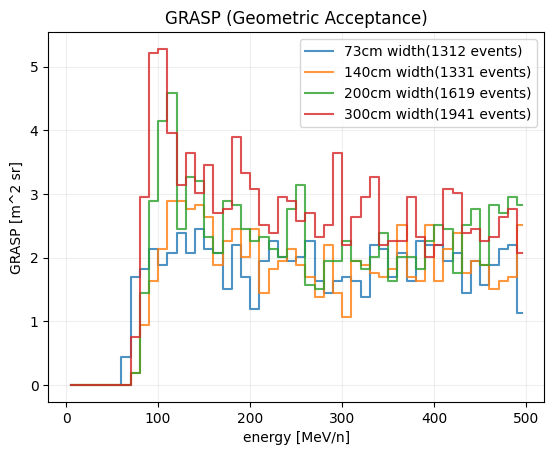

In [3]:
fig, ax = plt.subplots()

file_path_73 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e6_73cm.dat'
label1= '73cm width'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_73 = Analyze_GRASP(read_data_from_toymodel(file_path_73), -1000010020, stop_event=True, in_flight_event=True)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_73 = GRASP_hist(GRASP_73[0], -1000010020, label1, GRASP_73[1], 0, 1000, 50, ax=ax)

file_path_140 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e6_140cm.dat'
label2= '140cm width'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_140 = Analyze_GRASP(read_data_from_toymodel(file_path_140), -1000010020, stop_event=True, in_flight_event=True)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_140 = GRASP_hist(GRASP_140[0], -1000010020, label2, GRASP_140[1], 0, 1000, 50, ax=ax)

file_path_200 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e6_200cm.dat'
label3 = '200cm width'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_200 = Analyze_GRASP(read_data_from_toymodel(file_path_200), -1000010020, stop_event=True, in_flight_event=True)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_200 = GRASP_hist(GRASP_200[0], -1000010020, label3, GRASP_200[1], 0, 1000, 50, ax=ax)

file_path_300 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e6_300cm.dat'
label4= '300cm width'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_300 = Analyze_GRASP(read_data_from_toymodel(file_path_300), -1000010020, stop_event=True, in_flight_event=True)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_300 = GRASP_hist(GRASP_300[0], -1000010020, label4, GRASP_300[1], 0, 1000, 50, ax=ax)

plt.show()  # Display the plot with both data on the same axes


Reading data...

Toy Model data imported
Found 1312 Events!
Now processing (1311/1312)
 We got 267 events selected
Last event is 999553
Reading data...

Toy Model data imported
Found 1941 Events!
Now processing (1940/1941)
 We got 386 events selected
Last event is 999712


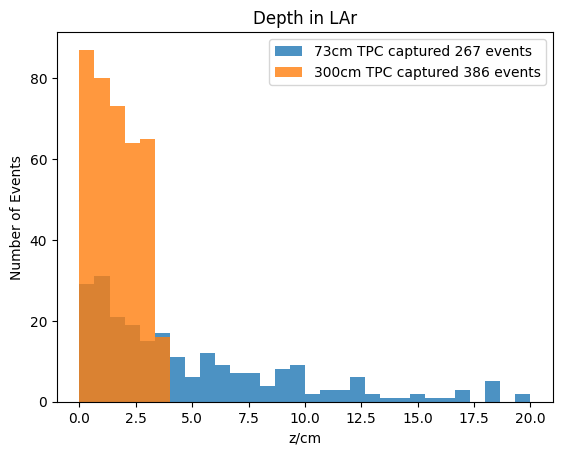

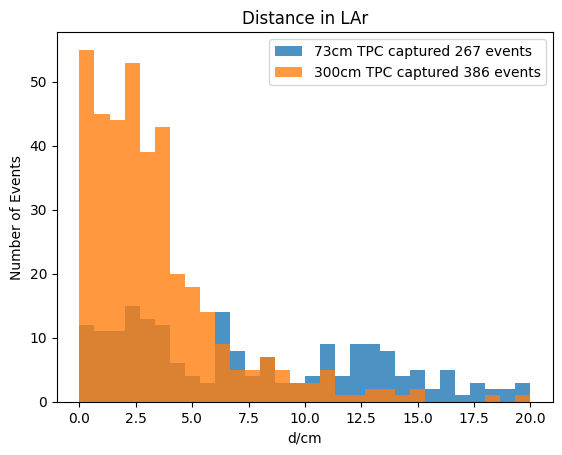

In [4]:
file_path_73 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e6_73cm.dat'
label1= '73cm width'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
trace_73 = Analyze_trace(read_data_from_toymodel(file_path_73), -1000010020, stop_event=True, in_flight_event=False)

file_path_300 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e6_300cm.dat'
label1= '300cm width'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
trace_300 = Analyze_trace(read_data_from_toymodel(file_path_300), -1000010020, stop_event=True, in_flight_event=False)

plt.figure(1)
plt.hist(trace_73[1], bins = 30, alpha = 0.8, label='73cm TPC captured '+ str(len(trace_73[1]))+' events', range=[0, 20])
plt.hist(trace_300[1], bins = 30, alpha = 0.8, label='300cm TPC captured '+ str(len(trace_300[1]))+' events', range=[0, 20])
plt.title("Depth in LAr")
plt.xlabel("z/cm")
plt.ylabel("Number of Events")
plt.legend()

plt.figure(2)
plt.hist(trace_73[2], bins = 30, alpha = 0.8, label='73cm TPC captured '+ str(len(trace_73[1]))+' events', range=[0, 20])
plt.hist(trace_300[2], bins = 30, alpha = 0.8, label='300cm TPC captured '+ str(len(trace_300[1]))+' events', range=[0, 20])
plt.title("Distance in LAr")
plt.xlabel("d/cm")
plt.ylabel("Number of Events")
plt.legend()

Reading data...

Toy Model data imported
Found 1565 Events!
Now processing (1564/1565)
 We got 318 events selected
Last event is 999484
Reading data...

Toy Model data imported
Found 1312 Events!
Now processing (1311/1312)
 We got 267 events selected
Last event is 999553


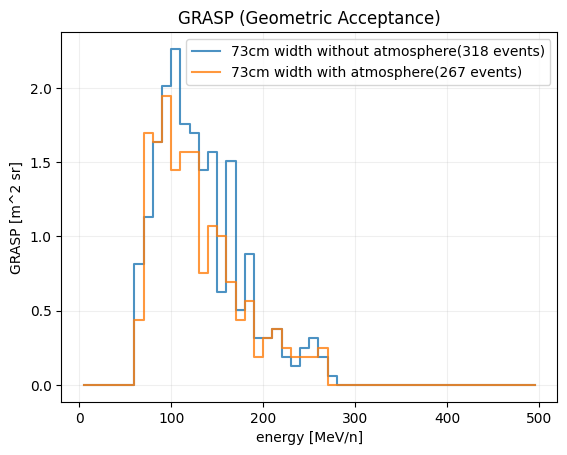

In [5]:
fig, ax = plt.subplots()

file_path_73_no_atmo = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_1e6_73cm.dat'
label1= '73cm width without atmosphere'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_73_no_atmo = Analyze_GRASP(read_data_from_toymodel(file_path_73_no_atmo), -1000010020, stop_event=True, in_flight_event=False)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_73_no_atmo = GRASP_hist(GRASP_73_no_atmo[0], -1000010020, label1, GRASP_73_no_atmo[1], 0, 1000, 50, ax=ax)

file_path_73_atmo = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e6_73cm.dat'
label2= '73cm width with atmosphere'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_73_atmo = Analyze_GRASP(read_data_from_toymodel(file_path_73_atmo), -1000010020, stop_event=True, in_flight_event=False)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_73_atmo = GRASP_hist(GRASP_73_atmo[0], -1000010020, label2, GRASP_73_atmo[1], 0, 1000, 50, ax=ax)

plt.show()  # Display the plot with both data on the same axes


Reading data...

Toy Model data imported
Found 1312 Events!
Now processing (1311/1312)
 We got 267 events selected
Last event is 999553
Reading data...

Toy Model data imported
Found 1113 Events!
Now processing (1112/1113)
 We got 229 events selected
Last event is 997995
Reading data...

Toy Model data imported
Found 1130 Events!
Now processing (1129/1130)
 We got 216 events selected
Last event is 999574
Reading data...

Toy Model data imported
Found 1331 Events!
Now processing (1330/1331)
 We got 279 events selected
Last event is 998550
Reading data...

Toy Model data imported
Found 1542 Events!
Now processing (1541/1542)
 We got 308 events selected
Last event is 998606
Reading data...

Toy Model data imported
Found 1531 Events!
Now processing (1530/1531)
 We got 308 events selected
Last event is 999969
Reading data...

Toy Model data imported
Found 1619 Events!
Now processing (1618/1619)
 We got 324 events selected
Last event is 999923
Reading data...

Toy Model data imported
Found 1

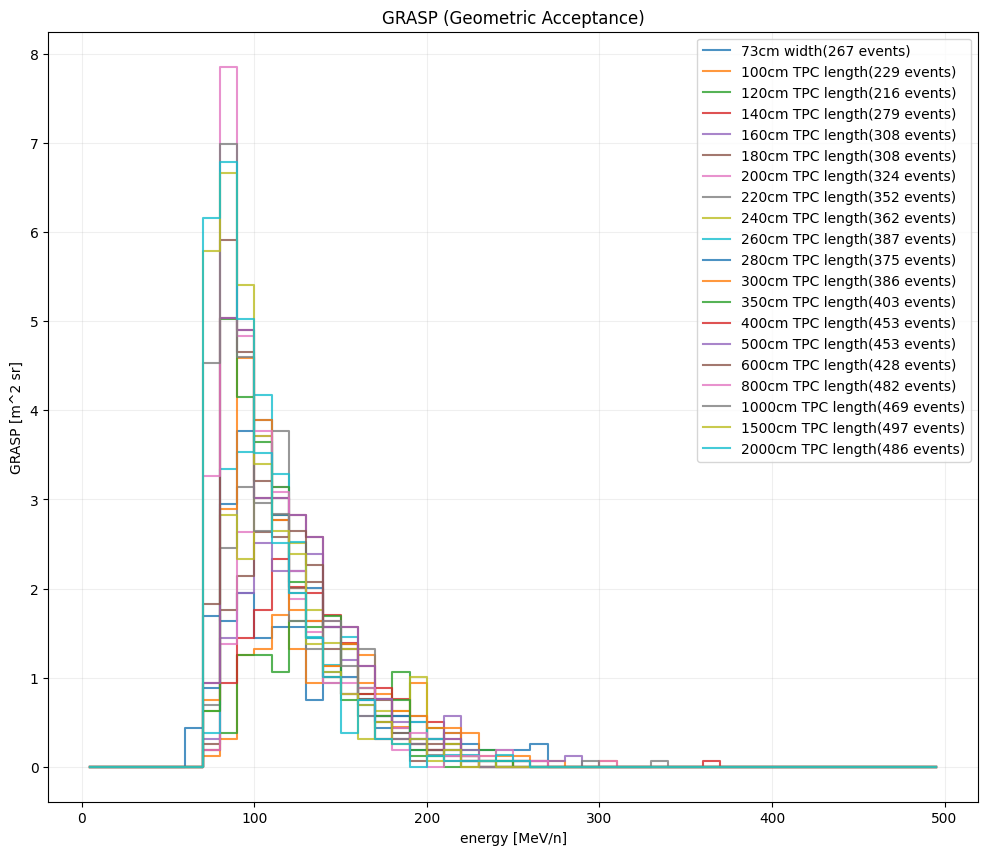

In [6]:
fig, ax = plt.subplots(figsize=(12, 10))

file_path_atmo_73 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e6_73cm.dat'
label1= '73cm width'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_73 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_73), -1000010020, stop_event=True, in_flight_event=False)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_73 = GRASP_hist(GRASP_73[0], -1000010020, label1, GRASP_73[1], 0, 1000, 50, ax=ax)

file_path_atmo_100 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e6_100cm.dat'
label2= '100cm TPC length'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_100 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_100), -1000010020, stop_event=True, in_flight_event=False)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_100 = GRASP_hist(GRASP_100[0], -1000010020, label2, GRASP_100[1], 0, 1000, 50, ax=ax)

file_path_atmo_120 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e6_120cm.dat'
label3 = '120cm TPC length'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_120 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_120), -1000010020, stop_event=True, in_flight_event=False)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_120 = GRASP_hist(GRASP_120[0], -1000010020, label3, GRASP_120[1], 0, 1000, 50, ax=ax)


file_path_atmo_140 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e6_140cm.dat'
label4= '140cm TPC length'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_140 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_140), -1000010020, stop_event=True, in_flight_event=False)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_140 = GRASP_hist(GRASP_140[0], -1000010020, label4, GRASP_140[1], 0, 1000, 50, ax=ax)

file_path_atmo_160 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e6_160cm.dat'
label5= '160cm TPC length'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_160 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_160), -1000010020, stop_event=True, in_flight_event=False)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_160 = GRASP_hist(GRASP_160[0], -1000010020, label5, GRASP_160[1], 0, 1000, 50, ax=ax)

file_path_atmo_180 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e6_180cm.dat'
label6= '180cm TPC length'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_180 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_180), -1000010020, stop_event=True, in_flight_event=False)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_180 = GRASP_hist(GRASP_180[0], -1000010020, label6, GRASP_180[1], 0, 1000, 50, ax=ax)

file_path_atmo_200 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e6_200cm.dat'
label7= '200cm TPC length'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_200 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_200), -1000010020, stop_event=True, in_flight_event=False)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_200 = GRASP_hist(GRASP_200[0], -1000010020, label7, GRASP_200[1], 0, 1000, 50, ax=ax)

file_path_atmo_220 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e6_220cm.dat'
label8= '220cm TPC length'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_220 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_220), -1000010020, stop_event=True, in_flight_event=False)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_220 = GRASP_hist(GRASP_220[0], -1000010020, label8, GRASP_220[1], 0, 1000, 50, ax=ax)

file_path_atmo_240 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e6_240cm.dat'
label9= '240cm TPC length'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_240 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_240), -1000010020, stop_event=True, in_flight_event=False)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_240 = GRASP_hist(GRASP_240[0], -1000010020, label9, GRASP_240[1], 0, 1000, 50, ax=ax)

file_path_atmo_260 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e6_260cm.dat'
label10= '260cm TPC length'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_260 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_260), -1000010020, stop_event=True, in_flight_event=False)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_260 = GRASP_hist(GRASP_260[0], -1000010020, label10, GRASP_260[1], 0, 1000, 50, ax=ax)

file_path_atmo_280 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e6_280cm.dat'
label11= '280cm TPC length'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_280 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_280), -1000010020, stop_event=True, in_flight_event=False)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_280 = GRASP_hist(GRASP_280[0], -1000010020, label11, GRASP_280[1], 0, 1000, 50, ax=ax)

file_path_atmo_300 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e6_300cm.dat'
label12= '300cm TPC length'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_300 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_300), -1000010020, stop_event=True, in_flight_event=False)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_300 = GRASP_hist(GRASP_300[0], -1000010020, label12, GRASP_300[1], 0, 1000, 50, ax=ax)

file_path_atmo_350 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e6_350cm.dat'
label13= '350cm TPC length'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_350 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_350), -1000010020, stop_event=True, in_flight_event=False)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_350 = GRASP_hist(GRASP_350[0], -1000010020, label13, GRASP_350[1], 0, 1000, 50, ax=ax)

file_path_atmo_400 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e6_400cm.dat'
label14= '400cm TPC length'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_400 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_400), -1000010020, stop_event=True, in_flight_event=False)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_400 = GRASP_hist(GRASP_400[0], -1000010020, label14, GRASP_400[1], 0, 1000, 50, ax=ax)

file_path_atmo_500 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e6_400cm.dat'
label15= '500cm TPC length'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_500 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_500), -1000010020, stop_event=True, in_flight_event=False)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_600 = GRASP_hist(GRASP_500[0], -1000010020, label15, GRASP_500[1], 0, 1000, 50, ax=ax)

file_path_atmo_600 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e6_500cm.dat'
label16= '600cm TPC length'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_600 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_600), -1000010020, stop_event=True, in_flight_event=False)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_600 = GRASP_hist(GRASP_600[0], -1000010020, label16, GRASP_600[1], 0, 1000, 50, ax=ax)

file_path_atmo_800 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e6_800cm.dat'
label17= '800cm TPC length'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_800 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_800), -1000010020, stop_event=True, in_flight_event=False)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_800 = GRASP_hist(GRASP_800[0], -1000010020, label17, GRASP_800[1], 0, 1000, 50, ax=ax)

file_path_atmo_1000 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e6_1000cm.dat'
label18= '1000cm TPC length'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1000 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_1000), -1000010020, stop_event=True, in_flight_event=False)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1000 = GRASP_hist(GRASP_1000[0], -1000010020, label18, GRASP_1000[1], 0, 1000, 50, ax=ax)

file_path_atmo_1500 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e6_1500cm.dat'
label19= '1500cm TPC length'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_1500 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_1500), -1000010020, stop_event=True, in_flight_event=False)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_1500 = GRASP_hist(GRASP_1500[0], -1000010020, label19, GRASP_1500[1], 0, 1000, 50, ax=ax)

file_path_atmo_2000 = '/home/jiancheng/GRAMS/toymodel_work/output/2023/GRASP_anti_deuteron_atmo_1e6_2000cm.dat'
label20= '2000cm TPC length'

# variable explaination: Analyze_GRASP(data_vector_constructed, Particle_ID_of_initial_particle, stop_event_inside_LAr, in_flight_event_inside_LAr)
GRASP_2000 = Analyze_GRASP(read_data_from_toymodel(file_path_atmo_2000), -1000010020, stop_event=True, in_flight_event=False)

# variable explaination: GRASP_hist(GRASP_vector_from_Analyze_GRASP_function, Particle_ID_of_initial_particle, label, total_number_of_events, minimal_ernegy, maximum_energy, number_of_bins, plot_ax_name)
plot_2000 = GRASP_hist(GRASP_2000[0], -1000010020, label20, GRASP_2000[1], 0, 1000, 50, ax=ax)

plt.show()  # Display the plot with both data on the same axes


Text(0.5, 1.0, '1e6 total events generated')

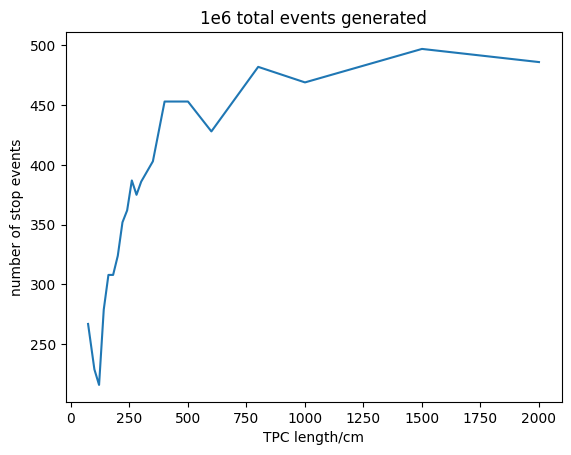

In [9]:
Stop_Events = [267, 229, 216, 279, 308, 308, 324, 352, 362, 387, 375, 386, 403, 453, 453, 428, 482, 469, 497, 486]
TPC_length = [73, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 350, 400, 500, 600, 800, 1000, 1500, 2000]

plt.plot(TPC_length, Stop_Events)
plt.xlabel("TPC length/cm")
plt.ylabel("number of stop events")
plt.title("1e6 total events generated")

In [11]:
TPC_thickness = 550/1.4*1000/(np.array(TPC_length)**2)
print(TPC_thickness)

[73.72061228 39.28571429 27.28174603 20.04373178 15.34598214 12.12522046
  9.82142857  8.11688312  6.82043651  5.8114962   5.01093294  4.36507937
  3.20699708  2.45535714  1.57142857  1.09126984  0.61383929  0.39285714
  0.17460317  0.09821429]


Text(0.5, 1.0, '1e6 total events generated')

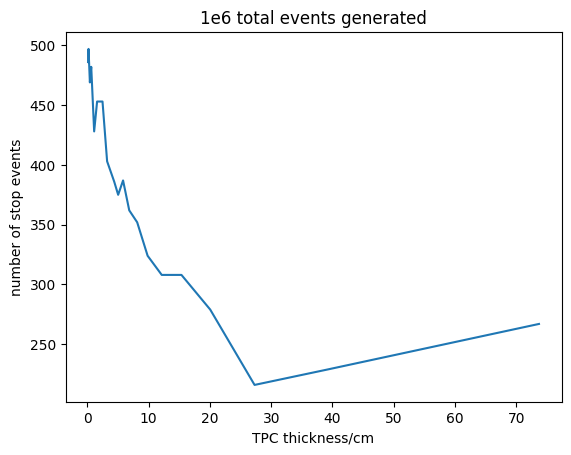

In [12]:
plt.plot(TPC_thickness, Stop_Events)
plt.xlabel("TPC thickness/cm")
plt.ylabel("number of stop events")
plt.title("1e6 total events generated")